# AST Generation

<br>
<center>
<table>
<tr>
<td>
<center>
<b>Polyhedral Model</b>
</center>
</td>
<td>
</td>
<td>
<center>
<b>Imperative Program</b>
</center>
</tr>

<tr>
<td>

<b>Iteration Domain</b>  <br>
$ \{ T[i,j] \mid 0 < i \le j < 10; S[i,0] \mid 0 < i \le 20 \}$   <br>
<br>

<b>Schedule</b>  <br>
$ \{ T[i,j] \to [i,j]; S[i,0] \to [i,j] \}$   

</td>
<td>

&nbsp; &nbsp; &nbsp; $ \rightarrow $ &nbsp; &nbsp; &nbsp; 

</td>
<td>
<center>
<br>

```c
const int N = 10;
double X[N], Y[N], Z[2*N];

for (int i = 0; i <= 2*N; ++i)
S:  Z[i] = 0.;
for (int i = 1; i <= N; ++i)
    for (int j = i; j <= N; ++j)
T:      Z[i + j] += A[i] * B[j];
```

</td>
</tr>
</table>
</center>

<br>

[Polyhedral AST generation is more than scanning polyhedra](https://dl.acm.org/doi/10.1145/2743016)
<!-- **Polyhedral AST generation is more than scanning polyhedra**  
Tobias Grosser, Sven Verdoolaege, Albert Cohen  
ACM Transations on Programming Languages and Systems (TOPLAS), 37(4), July 2015 -->

## Generate an AST
### Define a simple polyhedral program description


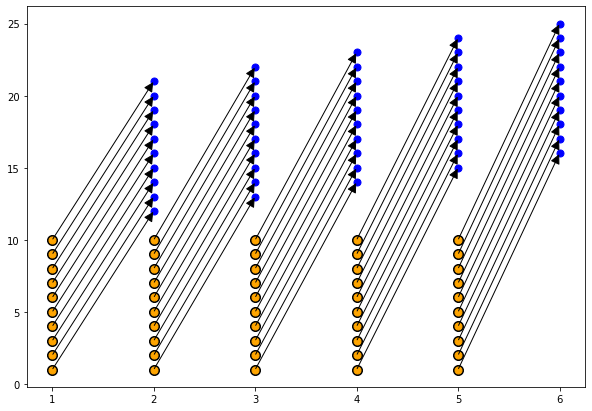

In [3]:
import islpy as isl
from islplot.plotter import *
import matplotlib.pyplot as plt
context = isl.Set("{ : }")
domain = isl.Set("{ S[t,i] : 1 <=t<=5 and 1<=i<=10 }")
schedule = isl.Map("{ S[t,i] -> T[t+1,i+t+10] }")

schedule_domain = schedule.intersect_domain(domain)
plt.figure(figsize=[10, 7])
plot_set_points(domain)
plot_map(schedule_domain)

## Translate polyhedral program description to an AST

<!-- The AST that is generated is an actual AST. It can be walked and inspected using tree operations. -->
最终生成的AST是实际的AST, 可以通过树操作对其进行遍历和检查.

In [4]:

class CSource():
  def __init__(self, ast):
    self.source = ast

  def _repr_html_(self):
    return "<pre class='code'><code class=\"cpp hljs\">" + self.source.to_C_str() + "</code></pre>"


class CSourceComparer():
  def __init__(self, before: CSource, after: CSource):
    self.before = before
    self.after = after

  def _repr_html_(self):
    s = "<b>Before Transform:</b>\n"
    s += self.before._repr_html_()
    s += "<b>After Transform:</b>\n"
    s += self.after._repr_html_()
    return s

def print_code(ast):
  return CSource(ast)

In [5]:
build = isl.AstBuild.from_context(context) 
ast = build.node_from_schedule_map(schedule.intersect_domain(domain))
print_code(ast) # 这里生成的domain实际上被isl进行了优化.

## AST Generation for Constraint Sets

<!-- When optimizing programs some transformations are often only valid
under certain conditions. To still apply such transformations it is
common to perform code versioning. The optimized version of the code is
executed if the conditions hold, an unoptimized version
of the code is executed otherwise. -->

通常只有当满足特定条件时才可以使用一些transformation优化程序, 要始终实施这种优化方式的话, 那么需要将代码分为不同版本, 当满足特定条件时执行优化后的代码, 否则执行非优化的代码.

<!-- A simple example could be: -->
一个简单的例子:
    
```c
void foo(long n, A[][100]) {
  for (i = 0; i < n; i++)
    for (j = 0; j < n; j++)
      A[i][j] += i+j;
}
```

<!-- This code only has simple dependences if j is smaller than 100. This
means n < 100. Hence we probably want to generate the following code: -->

这个代码代码当j小于100时会有更简单的依赖, 也就是要求`n<100`. 那么就可以使用如下的方法来保证优化后不出错误.

```c
void foo(long n, A[][100]) {
  if (n < 100)
    // optimized code
  else
    // otherwise
}
```

<!-- The isl AST generator allows for the generation of arbitrary
boolean conditions from a constraint set described by an isl set. -->
isl的AST generator允许生成任意来自isl的约束bool条件集合.


## A simple constraint set


In [8]:
condition = isl.Set("[n] -> {: n < 100}")
expr = build.expr_from_set(condition)
print(expr.to_C_str())

n <= 99


## Recovery of modulo expressions



In [9]:
condition = isl.Set("[n, m] -> {: n % 100 = 2}")
expr = build.expr_from_set(condition)
print(expr.to_C_str())

(n - 2) % 100 == 0


## Verification of complex conditions


In [11]:
condition = isl.Set("[n, m] -> {: (n != 0 implies m = 5) or n + m = 42}")
expr = build.expr_from_set(condition)
print(expr.to_C_str())

m == 5 || n == 0 || n + m == 42
